In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_again', 'X_train.npy'))
    labels = np.load(os.path.join('Data_again', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_again', 'X_test.npy'))
    labels = np.load(os.path.join('Data_again', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [3]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [4]:
test_labels

array([3, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 0, 1, 3, 3, 0, 1, 1, 1, 2, 2, 2,
       1, 0, 0, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 1, 1, 3, 0, 3, 0, 0, 2,
       2, 3, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 3, 0, 2, 2, 2, 1, 3, 1, 0,
       2, 0, 3, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 1, 3, 0, 3, 3, 0, 0,
       3, 1, 0, 2, 2, 0, 2, 3, 3, 0, 2, 0, 0, 0, 0, 1, 1, 1, 3, 3, 1, 1,
       3, 3, 2, 0, 0, 0, 2, 3, 3, 0, 0, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 2, 2, 2, 1, 2, 2, 3, 0, 3, 1, 0, 0, 1, 0, 1, 2, 1, 3, 0,
       0, 3, 0, 1, 2, 2, 1, 0, 1, 3, 1, 3, 1, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 2, 2, 3, 3, 1, 1, 0, 1, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 1, 3,
       2, 0, 2, 2, 1, 3, 2, 2, 3, 2, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 0, 1,
       2, 3, 2, 1, 0, 3, 3, 0, 0, 0, 0, 1, 2, 1, 1, 3, 3, 3, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 3, 0, 0, 1, 0, 3, 2, 3, 2, 0, 2, 3, 0, 0, 0, 0, 0,
       3, 1, 2, 1, 0, 0, 3, 0, 1, 0, 2, 3, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0,
       3, 0, 3, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 3,

In [5]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [7]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [8]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [9]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

from keras import backend as K

def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)

    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision


def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)

    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    return _f1score

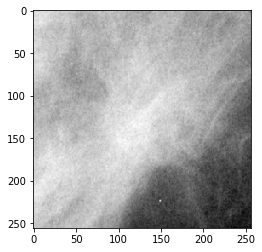

Label: [0. 0. 0. 1.]
[[[148.890625   148.890625   148.890625  ]
  [150.61328125 150.61328125 150.61328125]
  [151.359375   151.359375   151.359375  ]
  ...
  [ 76.77734375  76.77734375  76.77734375]
  [ 83.58203125  83.58203125  83.58203125]
  [ 81.53515625  81.53515625  81.53515625]]

 [[148.625      148.625      148.625     ]
  [153.640625   153.640625   153.640625  ]
  [153.5703125  153.5703125  153.5703125 ]
  ...
  [ 79.09375     79.09375     79.09375   ]
  [ 75.5234375   75.5234375   75.5234375 ]
  [ 83.046875    83.046875    83.046875  ]]

 [[154.39453125 154.39453125 154.39453125]
  [152.7421875  152.7421875  152.7421875 ]
  [155.0546875  155.0546875  155.0546875 ]
  ...
  [ 82.1875      82.1875      82.1875    ]
  [ 83.421875    83.421875    83.421875  ]
  [ 79.51953125  79.51953125  79.51953125]]

 ...

 [[128.0390625  128.0390625  128.0390625 ]
  [133.72265625 133.72265625 133.72265625]
  [130.85546875 130.85546875 130.85546875]
  ...
  [150.0078125  150.0078125  150.0078125

In [10]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 789

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [15]:
self_model = Sequential()
self_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
self_model.add(MaxPooling2D(pool_size=(2,2)))
self_model.add(Conv2D(64, (3,3), activation='relu'))
self_model.add(MaxPooling2D(pool_size=(2,2)))
self_model.add(Conv2D(64, (3,3), activation='relu'))

self_model.add(Flatten())
self_model.add(Dense(128, activation='relu'))
self_model.add(Dense(64, activation='relu'))
self_model.add(Dense(64, activation='relu'))
self_model.add(Dense(4, activation='softmax'))

self_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      9280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [16]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
self_model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('self_model2_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
self_model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Train
history_self_model = self_model.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 12287.1481 - accuracy: 0.2531
Epoch 00001: val_loss improved from inf to 1.36793, saving model to self_model2_best.h5
11/11 [==============================] - 21s 2s/step - loss: 11199.4016 - accuracy: 0.2450 - val_loss: 1.3679 - val_accuracy: 0.3454
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.8426 - accuracy: 0.3023
Epoch 00002: val_loss improved from 1.36793 to 1.36498, saving model to self_model2_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.8840 - accuracy: 0.3061 - val_loss: 1.3650 - val_accuracy: 0.3419
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3624 - accuracy: 0.3418
Epoch 00003: val_loss improved from 1.36498 to 1.35151, saving model to self_model2_best.h5
11/11 [==============================] - 20s 2s/step - loss: 1.3644 - accuracy: 0.3366

10/11 [==========================>...] - ETA: 1s - loss: 1.3558 - accuracy: 0.3398
Epoch 00029: val_loss did not improve from 1.34795
11/11 [==============================] - 20s 2s/step - loss: 1.3586 - accuracy: 0.3352 - val_loss: 1.3487 - val_accuracy: 0.3454
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3684 - accuracy: 0.3297
Epoch 00030: val_loss did not improve from 1.34795
11/11 [==============================] - 21s 2s/step - loss: 1.3697 - accuracy: 0.3260 - val_loss: 1.3509 - val_accuracy: 0.3454
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3546 - accuracy: 0.3494
Epoch 00031: val_loss did not improve from 1.34795
11/11 [==============================] - 19s 2s/step - loss: 1.3578 - accuracy: 0.3435 - val_loss: 1.3499 - val_accuracy: 0.3436
Epoch 32/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3701 - accuracy: 0.3242
Epoch 00032: val_loss did not improve from 1.34795
11/11 [==============================]

In [29]:
# Save
models.save_model(self_model, 'self_model2_end.h5')

In [30]:
# History of accuracy and loss
tra_loss_fe = history_self_model.history['loss']
tra_acc_fe = history_self_model.history['accuracy']
val_loss_fe = history_self_model.history['val_loss']
val_acc_fe = history_self_model.history['val_accuracy']

In [31]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_self_model = models.load_model('self_model2_best.h5')
test_loss_fe, test_acc_fe = self_model.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_self_model.evaluate(test_images, test_labels, verbose=False)

In [32]:
print("self_model2 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

self_model2 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 35
Epoch [opt]: 5
Valid accuracy [end]: 0.3454
Valid accuracy [opt]: 0.3436
Test accuracy [end]:  0.3191
Test accuracy [opt]:  0.3191
Valid loss [end]: 1.3512
Valid loss [opt]: 1.3479
Test loss [end]:  1.3785
Test loss [opt]:  1.3802


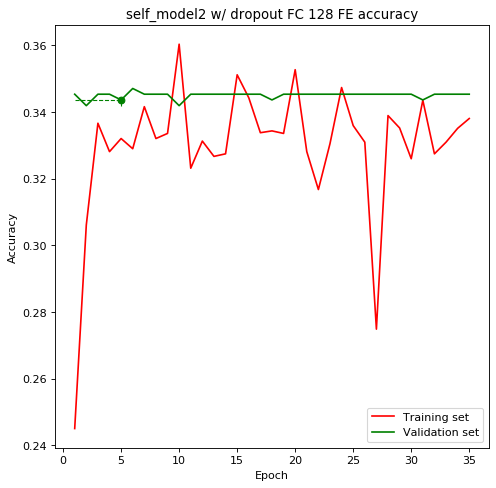

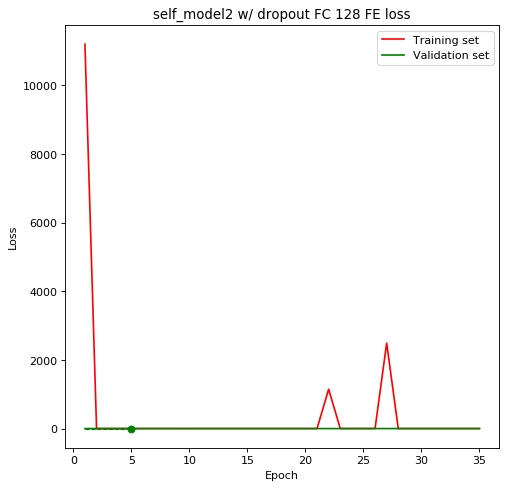

In [33]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('self_model2 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('self_model2 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();